# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

Grupo 1:
- Marquez, Micael 
- Mantovani, María Laura
- Ruales, Fanny
- Ruiz, Rodrigo Hernán

### Importación de librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import missingno as msno

### Lectura de archivo de datos desde Google Drive



In [2]:
# Al ejecutar el código, se mostrará una ventana solicitando permisos de acceso a Drive con la cuenta de correo (personal)
# se deben aceptar los permisos para poder acceder al archivo compartido que contiene el dataset a trabajar

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(filename)

drive = connect_to_drive()
salida_tp1 = read_csv_from_drive(drive, '1tabMlUV2m4bfH0m9s4578488h-kFh38n' , 'salida_TP1.csv')

In [3]:
#Copia del DF original
df_tp2 = salida_tp1.copy()

## 1. Valores nulos, outliers o erróneos


### a. Analizar los valores nulos existentes y su impacto en el análisis del problema


i. ¿Qué porcentaje representan los registros nulos de cada variable con respecto al total?

<font color='MediumBlue'>
En el práctico anterior ya se habían removido del dataset los registros con userId nulo, por lo que se sabe que esa variable ya no tiene nulos. Asimismo, del práctico 1 se sabe que las variables "artist", "song" y "length" son nulas para todos aquellos eventos distintos a "NextSong". La siguiente función analiza los valores nulos, ceros y únicos:

In [4]:
def status(data):
    data2=data
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)
status(df_tp2)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,ts,0,0.000000,0,0.000000,499351,int64
1,userId,0,0.000000,0,0.000000,448,int64
2,sessionId,0,0.000000,0,0.000000,4470,int64
3,page,0,0.000000,0,0.000000,19,object
4,auth,0,0.000000,0,0.000000,2,object
5,method,0,0.000000,0,0.000000,2,object
6,status,0,0.000000,0,0.000000,3,int64
7,level,0,0.000000,0,0.000000,2,object
8,itemInSession,0,0.000000,5147,0.009748,1006,int64
9,location,0,0.000000,0,0.000000,192,object


<font color='MediumBlue'>
En la tabla se observa que,  como se había encontrado en el práctico anterior, las variables "artist", "song" y "length" tienen registros nulos. Estos representan el 18% del total de los registros.<br>
Las variables agregadas: churn_cancellation, churn_downgrade y churn_cancellation_or_downgrade tienen una importante proporción de ceros, lo cual es esperable porque son variables dicotómicas con solo dos resultados posibles: 1 o 0 (churn o no churn).<br>
Asimismo, la variable days_reg_to_churn tiene una importante cantidad de valores faltantes porque solo existe el dato en el caso de usuarios que hicieron churn.<br>

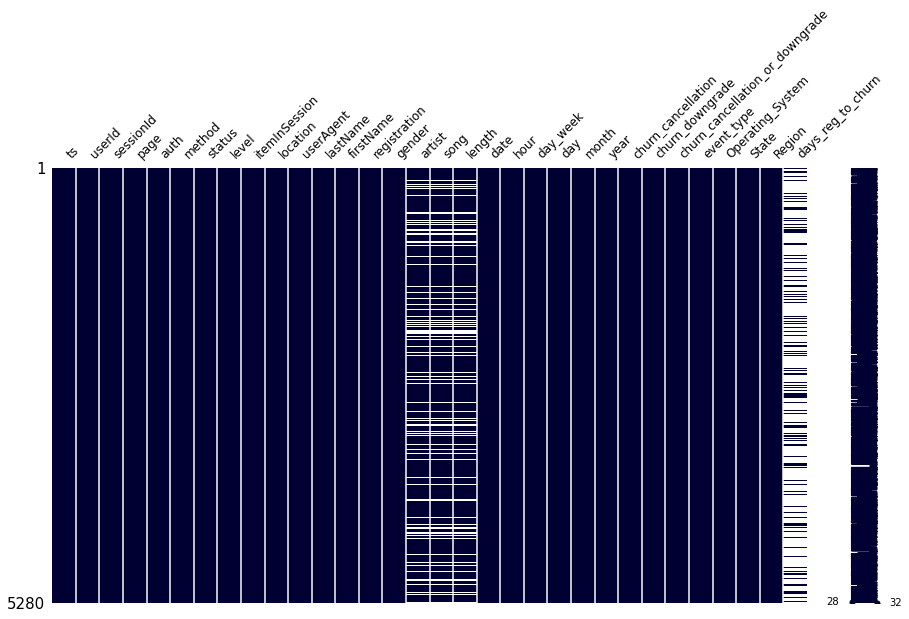

In [5]:
msno.matrix(df_tp2.sample(int(df_tp2.shape[0]*.01)),figsize=(15, 8), fontsize=12, color=[0,0,0.2])

<font color='MediumBlue'>
En el gráfico se observa nuevamente que las variables "artist", "song" y "length" tienen datos nulos para los mismos registros.<br>
<font color='MediumBlue'>
Finalmente, como se explicó anteriormente, la columna days_reg_to_churn presenta un gran número de datos faltantes.<br>
<font color='MediumBlue'>
También, en el gráfico, se puede apreciar que siempre que falta un dato de la columna "artist" también falta en "song" y "length". Se toma una muestra del set de datos para identificar la página donde se encuentra el usuario en esos casos.

In [6]:
df_tp2[(df_tp2.artist.isnull())]['page'].unique()

array(['Logout', 'Home', 'Downgrade', 'Add to Playlist', 'Roll Advert',
       'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend', 'Settings',
       'Save Settings', 'Upgrade', 'About', 'Submit Downgrade', 'Cancel',
       'Cancellation Confirmation', 'Submit Upgrade', 'Error'],
      dtype=object)

<font color='MediumBlue'>
Como se observó en el práctico anterior, las páginas que no tienen asociado "artist", "song" y "length" son todas excepto "NextSong".

ii. En base a esas cantidades, decida si es posible eliminar los registros,
imputarlos de alguna manera o predecirlos.

<font color='MediumBlue'>
En el práctico anterior se habían eliminado los registros con userId nulo. No se encontró otra alternativa que ésta, ya que no hay posibilidad de imputarlos (no se podría agrupar en distintos usuarios) y tampoco se puede analizar el comportamiento del usuario en la aplicación sin la información del usuario.
<br>
Los valores nulos "artist", "song" y "length" no son faltantes sino que es correcto que no existan para eventos diferentes de "NextSong". Por esto, no tiene sentido imputarlos ni predecirlos. Eliminarlos tampoco tiene sentido ya que, quitaríamos todos los eventos distintos de "NextSong". 

iii. Verificar si existen registros duplicados que pudieran representar luego
un problema al modelo de clasificación. ¿Qué acción tomaría sobre
ellos?

<font color='MediumBlue'>
No parece realista encontrar valores duplicados, considerando que se trata de una base de datos que se completa automáticamente con actividad de la aplicación (insertando el dato de time stamp para cada evento). Aún así se analizarán los registros para confirmar que no existan duplicados.

In [7]:
len(df_tp2)-len(df_tp2.drop_duplicates())

0

In [8]:
#otra forma de chequear
print(df_tp2[df_tp2.duplicated()].shape)
df_tp2[df_tp2.duplicated()]

(0, 32)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,month,year,churn_cancellation,churn_downgrade,churn_cancellation_or_downgrade,event_type,Operating_System,State,Region,days_reg_to_churn


<font color='MediumBlue'>
Se confirma la sospecha de que no hay registros repetidos en el dataset.

### b. Analizar si existen valores outliers en las variables numéricas, indagar si realmente son valores atípicos o son casos excepcionales que deben tenerse en cuenta. ¿Qué porcentaje representan? ¿Los eliminamos o mantenemos cierto porcentaje de ellos (percentiles)?

<font color='MediumBlue'>
La única variable numérica del data set orginal que tiene sentido revisar en términos de outliers es "length".

In [9]:
df_tp2.length.describe()

count    432877.000000
mean        248.664593
std          98.412670
min           0.783220
25%         199.392200
50%         234.004440
75%         276.793020
max        3024.665670
Name: length, dtype: float64

<font color='MediumBlue'>
En la tabla se advierte que la variable "length" tiene un máximo de 3024.67 segundos y un mínimo de 0.78. 

Text(0.5, 1.0, 'Histogram length')

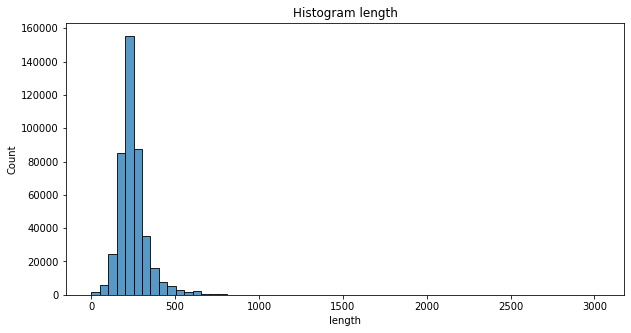

In [10]:
plt.figure(figsize = (10,5))
g = sns.histplot(df_tp2.length, bins=60)
g.set_title('Histogram length')

<font color='MediumBlue'> 
En el histograma se nota que la distribución de la variable se encuentra corrida hacia la izquierda debido a que hay pocos valores atípicos pero muy altos. 
Cabe preguntarse si esta variable tiene impacto sobre la variable target.

[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

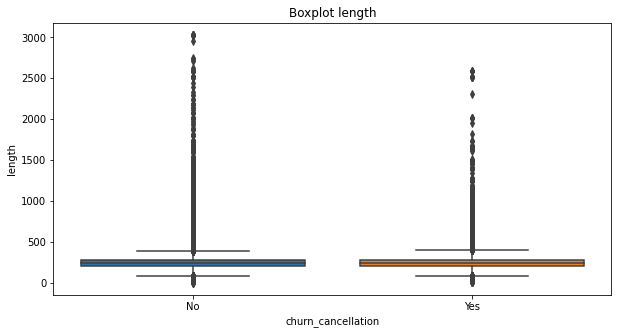

In [11]:
plt.figure(figsize = (10,5))
g = sns.boxplot(data=df_tp2,y="length", x='churn_cancellation')
g.set(title='Boxplot length')
g.set_xticklabels(['No', 'Yes'])

[Text(0.5, 1.0, 'Distribution length')]

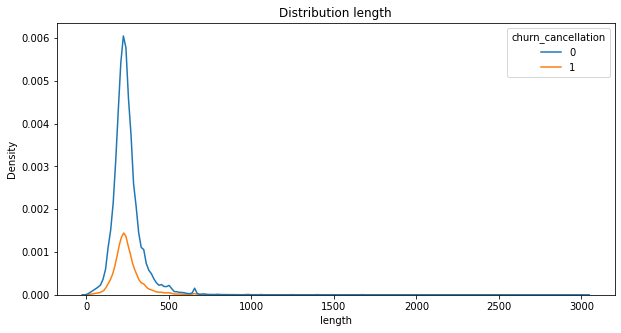

In [12]:
plt.figure(figsize = (10,5))
g = sns.kdeplot(data=df_tp2,x="length", hue='churn_cancellation')
g.set(title='Distribution length')

<font color='MediumBlue'>
Se observa que ambas clases tienen distribuciones similares.
Se elimina el 4% de los datos (2% superior y 2% inferior) para obtener un gráfico mas claro para analizar la conveniencia de eliminar definitivamente estos registros.

In [13]:
df_tp2.length.quantile(q=.02), df_tp2.length.quantile(q=.98)

(108.25098, 498.33751)

In [14]:
outliers = df_tp2[(df_tp2.length < (df_tp2.length.quantile(q=.02))) | (df_tp2.length > (df_tp2.length.quantile(q=.98)))]
print(len(outliers))
#outliers.sample(3)

17306


<font color='MediumBlue'> 
Se tienen 17.306 elementos que son considerados outliers en base a la duración de la canción. Se repiten los gráficos anteriores con el data set filtrado y comparándolo con los anteriores.

In [15]:
df_tp2_flt= df_tp2.drop(outliers.index,axis=0)

[Text(0.5, 1.0, '108.25 < length < 498.34 sec')]

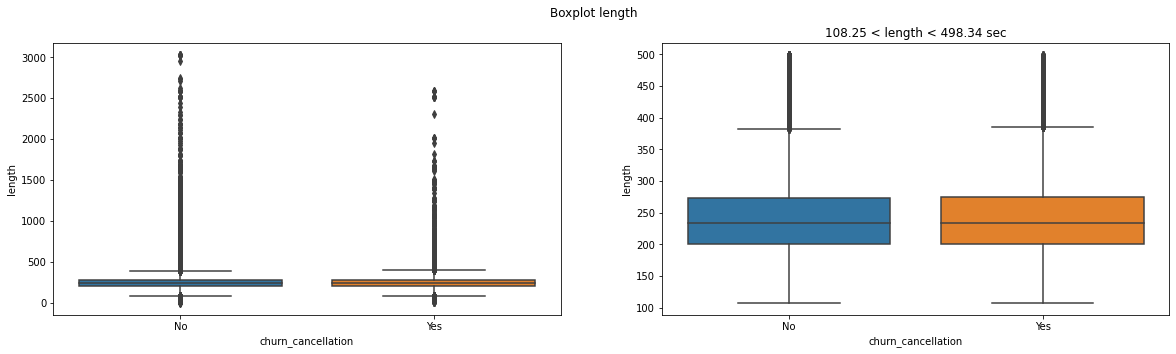

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=False)
sns.boxplot(data=df_tp2,y="length", x='churn_cancellation',ax=ax[0])
fig.suptitle('Boxplot length')
ax[0].set_xticklabels(['No', 'Yes'])
sns.boxplot(data=df_tp2_flt,y="length", x='churn_cancellation',ax=ax[1])
ax[1].set_xticklabels(['No', 'Yes'])
ax[1].set(title=f'{df_tp2.length.quantile(q=.02).round(2)} < length < {df_tp2.length.quantile(q=.98).round(2)} sec')

[Text(0.5, 1.0, '108.25 < length < 498.34 sec')]

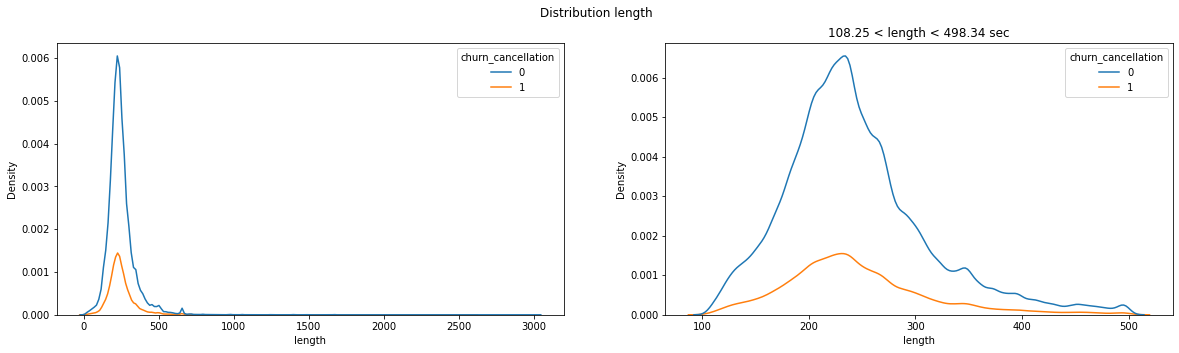

In [17]:
# sns.kdeplot(data=df_tp2.drop(outliers.index), x="length", hue='churn_cancellation')
fig, ax = plt.subplots(ncols=2, figsize=(20,5), sharey=False)
sns.kdeplot(data=df_tp2,x="length", hue='churn_cancellation',ax=ax[0])
fig.suptitle('Distribution length')
sns.kdeplot(data=df_tp2_flt,x="length", hue='churn_cancellation',ax=ax[1])
ax[1].set(title=f'{df_tp2.length.quantile(q=.02).round(2)} < length < {df_tp2.length.quantile(q=.98).round(2)} sec')

In [18]:
print("Existen",len(df_tp2.drop(outliers.index)),"datos una vez filtrados los outliers, y existen",len(df_tp2), "en el dataframe sin filtrar")
print("Se ha eliminado un", (100*(1-len(df_tp2.drop(outliers.index))/len(df_tp2))),"% de los datos")

Existen 510699 datos una vez filtrados los outliers, y existen 528005 en el dataframe sin filtrar
Se ha eliminado un 3.277620477078813 % de los datos


<font color='MediumBlue'>
El porcentaje final de registros eliminados es menor al 4% ya que existen datos nulos para la variable length. Como se mencionó antes, no tiene sentido eliminar los registros nulos de la variable "length" ya que quitaríamos todos los eventos distintos de "NextSong".

### c. ¿Existen valores erróneos? Analizar cómo tratarlos, si dejarlos como están porque tienen cierto significado, eliminar las filas donde están esos valores erróneos o imputarlos de alguna manera.

<font color='MediumBlue'>
Debido a que se trata de una base generada automáticamente por una app, parece poco factible que existan valores erróneos.</br>
Podrían ser valores erróneos, por ejemplo: registros con canción y sin nombre de artista/duración, o artistas sin nombre de canción/duración, o duraciones sin datos de canción/artista. En el TP1 se chequeó que siempre que faltaba el dato de una de estas 3 variables, faltaban también los 2 relacionados a éste. </br>
Otro dato erróneo podría ser que una misma sesión tenga 2 userid (asumiendo que el sessionId es un identificador único):

In [19]:
cuenta_sessionIds = df_tp2.groupby('sessionId')['userId'].nunique().sort_values(ascending=False).reset_index()
print(cuenta_sessionIds)

      sessionId  userId
0           374       4
1           189       4
2           378       4
3           193       4
4           196       4
...         ...     ...
4465       2163       1
4466       2164       1
4467       2165       1
4468       2166       1
4469       4808       1

[4470 rows x 2 columns]


<Figure size 720x360 with 0 Axes>

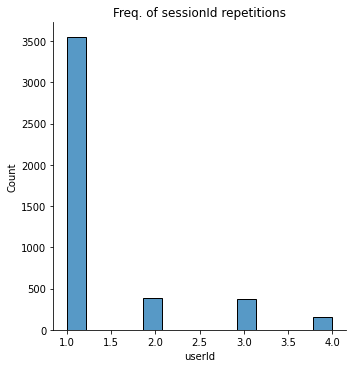

In [20]:
plt.figure(figsize = (10,5))
g = sns.displot(data=cuenta_sessionIds.userId)
g.set(title='Freq. of sessionId repetitions')

<font color='MediumBlue'>
Se observa que hay entre 1 y 4 userIds por sessionId. Parece entonces que el sessionId no es un dato único sino que será único al combinarlo con el userId.

### d. Concluir luego de ésta “limpieza” cuántos registros hemos mantenido/eliminado. Con el fin de no quedarnos con muy pocos registros para avanzar más adelante con algún modelo de clasificación.

<font color='MediumBlue'>
Más allá de los registros sin userId, se decide no eliminar registros ni hacer imputación por las razones expuestas en los puntos anteriores.

### e. Analizar cómo quedaron las clases churn y no churn luego de la limpieza del dataset, ¿se mantiene la proporción de cada clase?

<font color='MediumBlue'>
Dado que se conserva el set de datos tal como se extrajo del TP1, la observación de que las clases se encuentran desbalanceadas sigue aplicando.

## 2. Transformación de datos existentes

In [21]:
df_tp2.date = pd.to_datetime(df_tp2['date'])

### a. Pensar en nuevas columnas que puede ser útil generar. 

####Último “level” del usuario (‘paid’ o ‘free’). 

<font color='MediumBlue'>
El nivel de un usuario puede ser PAID o FREE. ¿Cuál es el último nivel registrado de cada usuario?
1 si el último nivel es "paid", en caso contrario 0.

In [22]:
#Se almacena la longitud del dataframe antes de realizar cualquier tipo de filtrado y transformación
len_before_filtering = len(df_tp2)


lv_trans = df_tp2.copy()
#Se crea una columna llamada level_t (level_transformed), que tendrá 2 posibles valores,
#siendo 1 en caso de que el usuario tenga level "paid", y 0 en caso de tener level "free"
lv_trans['level_t']= lv_trans['level'].apply(lambda x: "1" if "paid" in x else "0")
lv_trans.drop(labels=['level'],inplace=True,axis=1)

#Se ordena el dataframe por orden descendente (mayor en la cima), usando el ts como referencia.
aux_var = lv_trans.sort_values(by='ts', ascending=False)

#Se toman solamente 2 columnas de interés
aux_var = aux_var[['userId', 'level_t']]

#Se eliminan los userId duplicados, para obtener un único userId con su última fecha de registro
#en el dataset, para observar si su último estado es paid o free
aux_var.drop_duplicates(subset =['userId'], keep = 'first', inplace=True)
aux_var.rename(columns = {'level_t':'last_level'}, inplace = True)


In [23]:
#Se realiza un merge del df original junto con el df filtrado
#donde se le asignó el último level a cada usuario.
df_tp2 = df_tp2.merge(right = aux_var,
    how='left',
    left_on='userId', right_on='userId'
)


####Tiempo entre el registro y la última interacción

<font color='MediumBlue'>
¿Cuánto tiempo ha pasado desde el registro del usuario hasta su última interacción en la aplicación?

In [24]:
total_time = df_tp2.copy()
#Convertir registration en registration_date
total_time['registration'] = total_time['registration']/1000.0
total_time['registration'] = total_time['registration'].apply(np.int64)
# unit='s' to convert it into epoch time
total_time['registration_date']=pd.to_datetime(total_time['registration'], unit='s')

In [25]:
#Se reordenan los valores según el userId y ts, en orden ascendente.
total_time_filt = total_time.sort_values(by=['userId','registration_date'], ascending=[True,True])\
                                     .drop_duplicates(subset='userId', keep='last')
total_time_filt = total_time_filt[['userId','date','registration_date']]
total_time_filt['time_reg_to_last'] = total_time_filt['date'] -  total_time_filt['registration_date']
total_time_filt['time_reg_to_last'] = total_time_filt['time_reg_to_last'] / np.timedelta64(1,"D")
total_time_filt = total_time_filt[['userId','time_reg_to_last']]

df_tp2 = df_tp2.merge(right = total_time_filt,
    how='left',
    left_on='userId', right_on='userId'
)


● Artistas únicos por usuario

<font color='MediumBlue'>
¿Cuántos artistas únicos escucha cada usuario?

In [26]:
n_artists = df_tp2.copy(deep=True)

#Se filtran las columnas de interés, cuando el evento page es NextSong,
#y se agrupan los resultados.
n_artists = n_artists[n_artists['page'] == 'NextSong'][['userId','artist']]
n_artists = n_artists.groupby(['userId'])['artist'].nunique()

#Se convierte la información obtenida a un dataframe, y se les asigna 
#el userId como índice, para poder unirlo con el dataframe anterior.
df_n_artists = n_artists.to_frame()
df_n_artists['userIdd'] = df_n_artists.index
df_n_artists.reset_index(inplace=True)

df_n_artists.rename(columns = {'artist':'n_artists'}, inplace = True)

df_tp2 = df_tp2.merge(right = df_n_artists,
    how='left',
    left_on='userId', right_on='userIdd'
)

#Se acondicionan las columnas del dataframe obtenido.
df_tp2.drop(labels=['userIdd','userId_y'],axis=1)
df_tp2 = df_tp2.drop(labels=['userIdd','userId_y'],axis=1)

df_tp2.rename(columns = {'userId_x':'userId'}, inplace=True)

# df3_tp2.columns

####Canciones únicas por usuario

<font color='MediumBlue'>
¿Cuántas canciones únicas escucha cada usuario?

In [27]:
#Se aplica la misma lógica que para el item anterior.

n_songs = df_tp2.copy()
n_songs = n_songs[n_songs['page'] == 'NextSong'][['userId','song']]

n_songs = n_songs.groupby(['userId'])['song'].nunique()

df_n_songs = n_songs.to_frame()
df_n_songs['userIdd'] = df_n_songs.index
df_n_songs.reset_index(inplace=True)

df_n_songs.rename(columns = {'song':'n_songs'}, inplace = True)

aux1 = df_tp2.merge(right = df_n_songs,
    how='left',
    left_on='userId', right_on='userIdd'
)

#aux1.drop(labels=['userIdd','userId_y'],axis=1)
df_tp2 = aux1.drop(labels=['userIdd','userId_y'],axis=1)
df_tp2.rename(columns = {'userId_x':'userId'},inplace=True)

####Tiempo total de reproducción de canciones por usuario


<font color='MediumBlue'>
¿Cuánto tiempo estuvo escuchando música?

In [28]:
length_user = df_tp2.groupby(['userId'])['length'].sum().reset_index().rename(columns={'length': 'total_length'})
df_tp2 = df_tp2.merge(right=length_user, how='left', on='userId', validate='many_to_one')

<font color='MediumBlue'>
Como se puede ver, existe diferencia en el tiempo promedio de la duración de las canciones escuchadas entre las dos clases de usuarios.

####Tiempo total de reproducción de canciones por usuario y sesión

<font color='MediumBlue'>
¿Cuánto tiempo escucha música dentro de la sesion? Suma de length para ese usuario y esa sesion

In [29]:
length_user_session = df_tp2.groupby(['userId','sessionId'])['length'].sum().reset_index().rename(columns={'length': 'total_length_session'})
#Se crea una clave de union para poder unir los datos del dataframe con la suma de la duración de cada sesion para el usuario que corresponda.
#Esto es necesario porque los sessionId se repiten para distintos userId 
df_tp2['union_key']=df_tp2.userId.astype(str) + '-' + df_tp2.sessionId.astype(str)
length_user_session['union_key']=length_user_session.userId.astype(str) + '-' + length_user_session.sessionId.astype(str)
df_tp2 = df_tp2.merge(right=length_user_session[['union_key','total_length_session']], how='left', on='union_key', validate='many_to_one')
df_tp2.drop(labels=['union_key'],inplace=True,axis=1)

<font color='MediumBlue'>
Respecto al promedio de esucha de canciones durante la sesión, no se aprecian diferencias evidentes entre las dos clases de usuarios.

####Cantidad total de sesiones del usuario

<font color='MediumBlue'>
¿Cuántas sesiones diferentes hay de cada usuario?

In [30]:
df_sessions = df_tp2.drop_duplicates(subset =['userId', 'sessionId'], keep = 'first')
n_sessions = df_sessions.groupby(['userId'])['sessionId'].count().reset_index().rename(columns={'sessionId': 'n_sessions'})
df_tp2 = df_tp2.merge(right=n_sessions, how='left', on='userId', validate='many_to_one')

####Tiempo promedio de reproducción de música por usuario y sesión.

<font color='MediumBlue'>
¿Cuánto tiempo en promedio escucha música dentro de la sesion? Suma de length para ese usuario y esa sesion

In [31]:
df_tp2['avg_length_session'] = df_tp2.total_length / df_tp2.n_sessions

####Interacciones promedio por sesion con la página de error

In [32]:
n_error = df_tp2[df_tp2.page=='Error'].groupby(['userId'])['page'].count().reset_index().rename(columns={'page': 'n_error'})
df_tp2 = df_tp2.merge(right=n_error, how='left', on='userId', validate='many_to_one')
df_tp2['n_error'] = df_tp2['n_error'] .fillna(0)
df_tp2['avg_error_session'] = df_tp2.n_error / df_tp2.n_sessions

####Interacciones promedio por sesion con la página de ayuda

In [33]:
n_help = df_tp2[df_tp2.page=='Help'].groupby(['userId'])['page'].count().reset_index().rename(columns={'page': 'n_help'})
df_tp2 = df_tp2.merge(right=n_help, how='left', on='userId', validate='many_to_one')
df_tp2['n_help'] = df_tp2['n_help'] .fillna(0)
df_tp2['avg_help_session'] = df_tp2.n_help / df_tp2.n_sessions

####Cantidad total de interaccciones del usuario

In [34]:
n_interactions = df_tp2.groupby(['userId'])['page'].count().reset_index().rename(columns={'page': 'n_interactions'})
df_tp2 = df_tp2.merge(right=n_interactions, how='left', on='userId', validate='many_to_one')

#### Proporción de interacciones con la página de error sobre interacciones totales del usuario

In [35]:
df_tp2['prop_error'] = df_tp2.n_error / df_tp2.n_interactions

#### Proporción de interacciones con la página de ayuda sobre interacciones totales del usuario

In [36]:
df_tp2['prop_help'] = df_tp2.n_help / df_tp2.n_interactions

####Duración promedio de las sesiones

In [37]:
df_session_max = df_tp2.groupby(['userId','sessionId'])['date'].max().reset_index().rename(columns={'date': 'date_max'})
df_session_max['union_key']=df_session_max.userId.astype(str) + '-' + df_session_max.sessionId.astype(str)
df_session_min = df_tp2.groupby(['userId','sessionId'])['date'].min().reset_index().rename(columns={'date':  "date_min"})
df_session_min['union_key']=df_session_min.userId.astype(str) + '-' + df_session_min.sessionId.astype(str)
df_sessions = df_session_max.merge(right=df_session_min[['union_key','date_min']], how='left', on='union_key', validate='one_to_one')

df_sessions['session_duration'] = df_sessions['date_max'] -  df_sessions['date_min']
df_sessions['session_duration'] = df_sessions['session_duration'] / np.timedelta64(1,"m")

total_session = df_sessions.groupby(['userId'])['session_duration'].sum().reset_index().rename(columns={'session_duration': 'sessions_total_min'})
df_tp2 = df_tp2.merge(right=total_session, how='left', on='userId', validate='many_to_one')
df_tp2['avg_session_duration'] = df_tp2.sessions_total_min / df_tp2.n_sessions

####Cantidad total de Interacciones del usuario con las paginas mas interesantes



In [38]:

agg_cols=['userId', 'page']

agg_page=['Roll Advert', 'Thumbs Down', 'Add Friend', 'Thumbs Up','Submit Downgrade']
df_tp2_agregacion=df_tp2[agg_cols]

for i in range(len(agg_page)): 
 df_tp2_ki=df_tp2_agregacion[df_tp2_agregacion['page']==agg_page[i]].groupby('userId').count().reset_index()
 col='n_'+agg_page[i].replace(' ','')
 df_tp2_ki = df_tp2_ki.rename(columns={'page':col})  
 df_tp2 = df_tp2.merge(df_tp2_ki, how='left',left_on='userId', right_on='userId')
 df_tp2[col] =df_tp2[col].fillna(0)

####Tiempo desde la última interacción al último día de datos

In [39]:
# Se hace una copia del dataframe
nc1 = df_tp2.copy()
nc1.date = pd.to_datetime(nc1['date'])

In [40]:
# Para cada usuario, se obtiene la fecha de la última interacción registrada
user_max_date = nc1.groupby(by=['userId'],sort=True)['date'].max()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'date': 'user_max_date'})

In [41]:
# Se define la fecha del último día de datos
user_max_date['max_date'] =  pd.to_datetime(max(nc1['date']))

In [42]:
# Se obtiene la diferencia para cada usuario
user_max_date['dif'] = user_max_date.max_date - user_max_date.user_max_date

In [43]:
# Se convierte la diferencia al formato días
user_max_date['days_from_last_interaction'] = user_max_date.dif / np.timedelta64(1,"D")
user_max_date['days_from_last_interaction'] = user_max_date['days_from_last_interaction'].round(0).astype(int)

In [44]:
# Se convierte la diferencia al formato días
user_max_date['days_from_last_interaction'] = user_max_date.dif / np.timedelta64(1,"D")
user_max_date['days_from_last_interaction'] = user_max_date['days_from_last_interaction'].round(0).astype(int)

In [45]:
# Se eliminan las columnas auxiliares
user_max_date.drop(user_max_date.loc[:, 'user_max_date':'dif'].columns, axis=1, inplace=True)

In [46]:
# Se agrega la nueva columna al dataframe original
df_tp2 = df_tp2.set_index('userId').join(user_max_date.set_index('userId')).reset_index()

####Promedio en días de intervalo entre sesiones por usuario

In [47]:
# Se hace una copia del dataframe
nc2 = df_tp2.copy()
nc2.date = pd.to_datetime(nc2['date'])

In [48]:
# Se crea como índice una nueva columna que combina userID y sessionId
nc2['user_session'] = nc2['userId'].astype(str) + '-' + nc2['sessionId'].astype(str)

In [49]:
# Se crean datasets agrupados
df_min_date = nc2.groupby(by=['user_session'],sort=False)['date'].min()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'date': 'session_min_date'})
df_max_date = nc2.groupby(by=['user_session'],sort=False)['date'].max()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'date': 'session_max_date'})
df_min_user_date = nc2.groupby(by=['userId'],sort=False)['date'].min()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'date': 'user_min_date'})
                                                        

In [50]:
# Se unen los primeros dos df
df_minmax = df_min_date.set_index('user_session').join(df_max_date.set_index('user_session')).reset_index()

In [51]:
# Se agrega también el userId para ordenar y para juntarlo con la fecha minima de ese usuario (sin importar la sesión)
df_minmax['userId'] = df_minmax.user_session.str.rsplit(pat='-', n=2, expand=True)[0]

In [52]:
# Se unifican los formatos
df_minmax['userId'] = df_minmax['userId'].astype('int64')
df_min_user_date['userId'] = df_min_user_date['userId'].astype('int64')

In [53]:
# Se une df_minmax y df_min_user_date
df_minmax = df_minmax.set_index('userId').join(df_min_user_date.set_index('userId')).reset_index()

In [54]:
# Se ordena por la fecha mínima para cada usuario
df_minmax_sorted = df_minmax.sort_values(by=['userId','session_min_date'], ascending=True, inplace=False)

In [55]:
# Se crea una columna con la diferencia de días entre una sesión y otra por usuario
df_minmax_sorted['time_bt_sessions'] = df_minmax_sorted['session_min_date'] - df_minmax_sorted['session_max_date'].shift(1)

In [56]:
# Se anulan los time_bt_sessions en los que se trata de la primera sesión del usuario
df_minmax_sorted.loc[df_minmax_sorted['session_min_date'] == df_minmax_sorted['user_min_date'], 'time_bt_sessions'] = np.nan

In [57]:
# Se calcula el promedio de time_bt_sessions
averages = df_minmax_sorted.groupby(by=['userId'],sort=False)['time_bt_sessions'].mean()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'time_bt_sessions': 'average'})

In [58]:
# Se convierte el promedio al formato días
averages = averages.dropna()
averages['aux1'] = averages['average'] / np.timedelta64(1,"D")
averages.drop('average', axis=1, inplace=True)
averages['average_days_bt_session'] =  averages['aux1'].astype(float)
averages.drop('aux1', axis=1, inplace=True)

In [59]:
# Se agrega la nueva columna al dataframe original
df_tp2 = df_tp2.set_index('userId').join(averages.set_index('userId')).reset_index()

####Cantidad de dias distintos de cada usuario en la app

In [60]:
# Se hace una copia del dataframe
nc4 = df_tp2.copy()
# Se convierte la fecha al formato YYYY-MM-DD
nc4['date'] = pd.to_datetime(nc4['date']).dt.date

In [61]:
# Se cuentan los días distintos por usuario en la app
distinct_count = nc4.groupby(by=['userId'],sort=False)['date'].nunique()\
                                                            .sort_values(ascending=False)\
                                                            .reset_index()\
                                                            .rename(columns={'date': 'distinct_count_of_days'})

In [62]:
# Se agrega la nueva columna al dataframe original
df_tp2 = df_tp2.set_index('userId').join(distinct_count.set_index('userId')).reset_index()

#### Vistas acumuladas de la página de error por usuario

In [63]:
# Se ordena el dataset por usuario y por fecha
df_tp2 = df_tp2.sort_values(['userId', 'date'],
              ascending = [True, True])

In [64]:
# Se agrega una columna que cuenta la ocurrencia por fila de la página de error
df_tp2['if_error']=df_tp2.page.apply(lambda x: 1 if x == 'Error' else 0) 

# Se calcula el acumulado de esa columna por usuario
df_tp2['error_count'] = df_tp2.groupby(['userId'])['if_error'].cumsum()

#Se verifica que la columna acumule en la página de error (en ninguna otra)
df_tp2[['userId','date','page','error_count']][159:163]

,userId,date,page,error_count
159,2,2018-10-16 21:37:37,NextSong,0
160,2,2018-10-16 21:40:57,NextSong,0
161,2,2018-10-16 21:40:57,Error,1
162,2,2018-10-16 21:46:08,NextSong,1


In [65]:
# Se verifica que la variable vuelva a valer cero cuando cambie de usuario
df_tp2[['userId','date','page','error_count']][939:943]

,userId,date,page,error_count
939,2,2018-11-30 21:25:36,Save Settings,1
940,2,2018-11-30 21:25:38,Home,1
941,3,2018-11-28 09:02:16,NextSong,0
942,3,2018-11-28 09:06:30,NextSong,0


In [66]:
df_tp2[df_tp2.error_count > 1].head(2)

,userId,ts,sessionId,page,auth,method,status,level,itemInSession,location,...,n_RollAdvert,n_ThumbsDown,n_AddFriend,n_ThumbsUp,n_SubmitDowngrade,days_from_last_interaction,average_days_bt_session,distinct_count_of_days,if_error,error_count
1338,4,1542725574,4161,Error,Logged In,GET,404,free,20,"Baltimore-Columbia-Towson, MD",...,36.0,6.0,7.0,27.0,0.0,1,3.704827,13,1,2
1339,4,1542725575,4161,Logout,Logged In,PUT,307,free,21,"Baltimore-Columbia-Towson, MD",...,36.0,6.0,7.0,27.0,0.0,1,3.704827,13,0,2


#### Vistas acumuladas de la página de error por usuario

In [67]:
# Se repite el código de la variable anterior, para la página de ayuda
df_tp2['if_help']=df_tp2.page.apply(lambda x: 1 if x == 'Help' else 0) 

# Se calcula el acumulado de esa columna por usuario
df_tp2['help_count'] = df_tp2.groupby(['userId'])['if_help'].cumsum()

#### Gráficos de las variables recientemente añadidas

<font color='MediumBlue'>
Se grafican inicialmente las variables numéricas por usuario:

In [68]:
df_tp2.columns

Index(['userId', 'ts', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length',
       'date', 'hour', 'day_week', 'day', 'month', 'year',
       'churn_cancellation', 'churn_downgrade',
       'churn_cancellation_or_downgrade', 'event_type', 'Operating_System',
       'State', 'Region', 'days_reg_to_churn', 'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_co

In [69]:
df_users = df_tp2.drop_duplicates(subset =['userId'], keep = 'first')

In [70]:
# Estas columnas hay que cambiarlas porque estan las variables repetidas y ver como graficamos "last level"
cols_interest = ['days_reg_to_churn', 'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days']
n_cols = len(cols_interest)
print('Cantidad de columnas a graficar: ' + str(n_cols))

Cantidad de columnas a graficar: 24


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


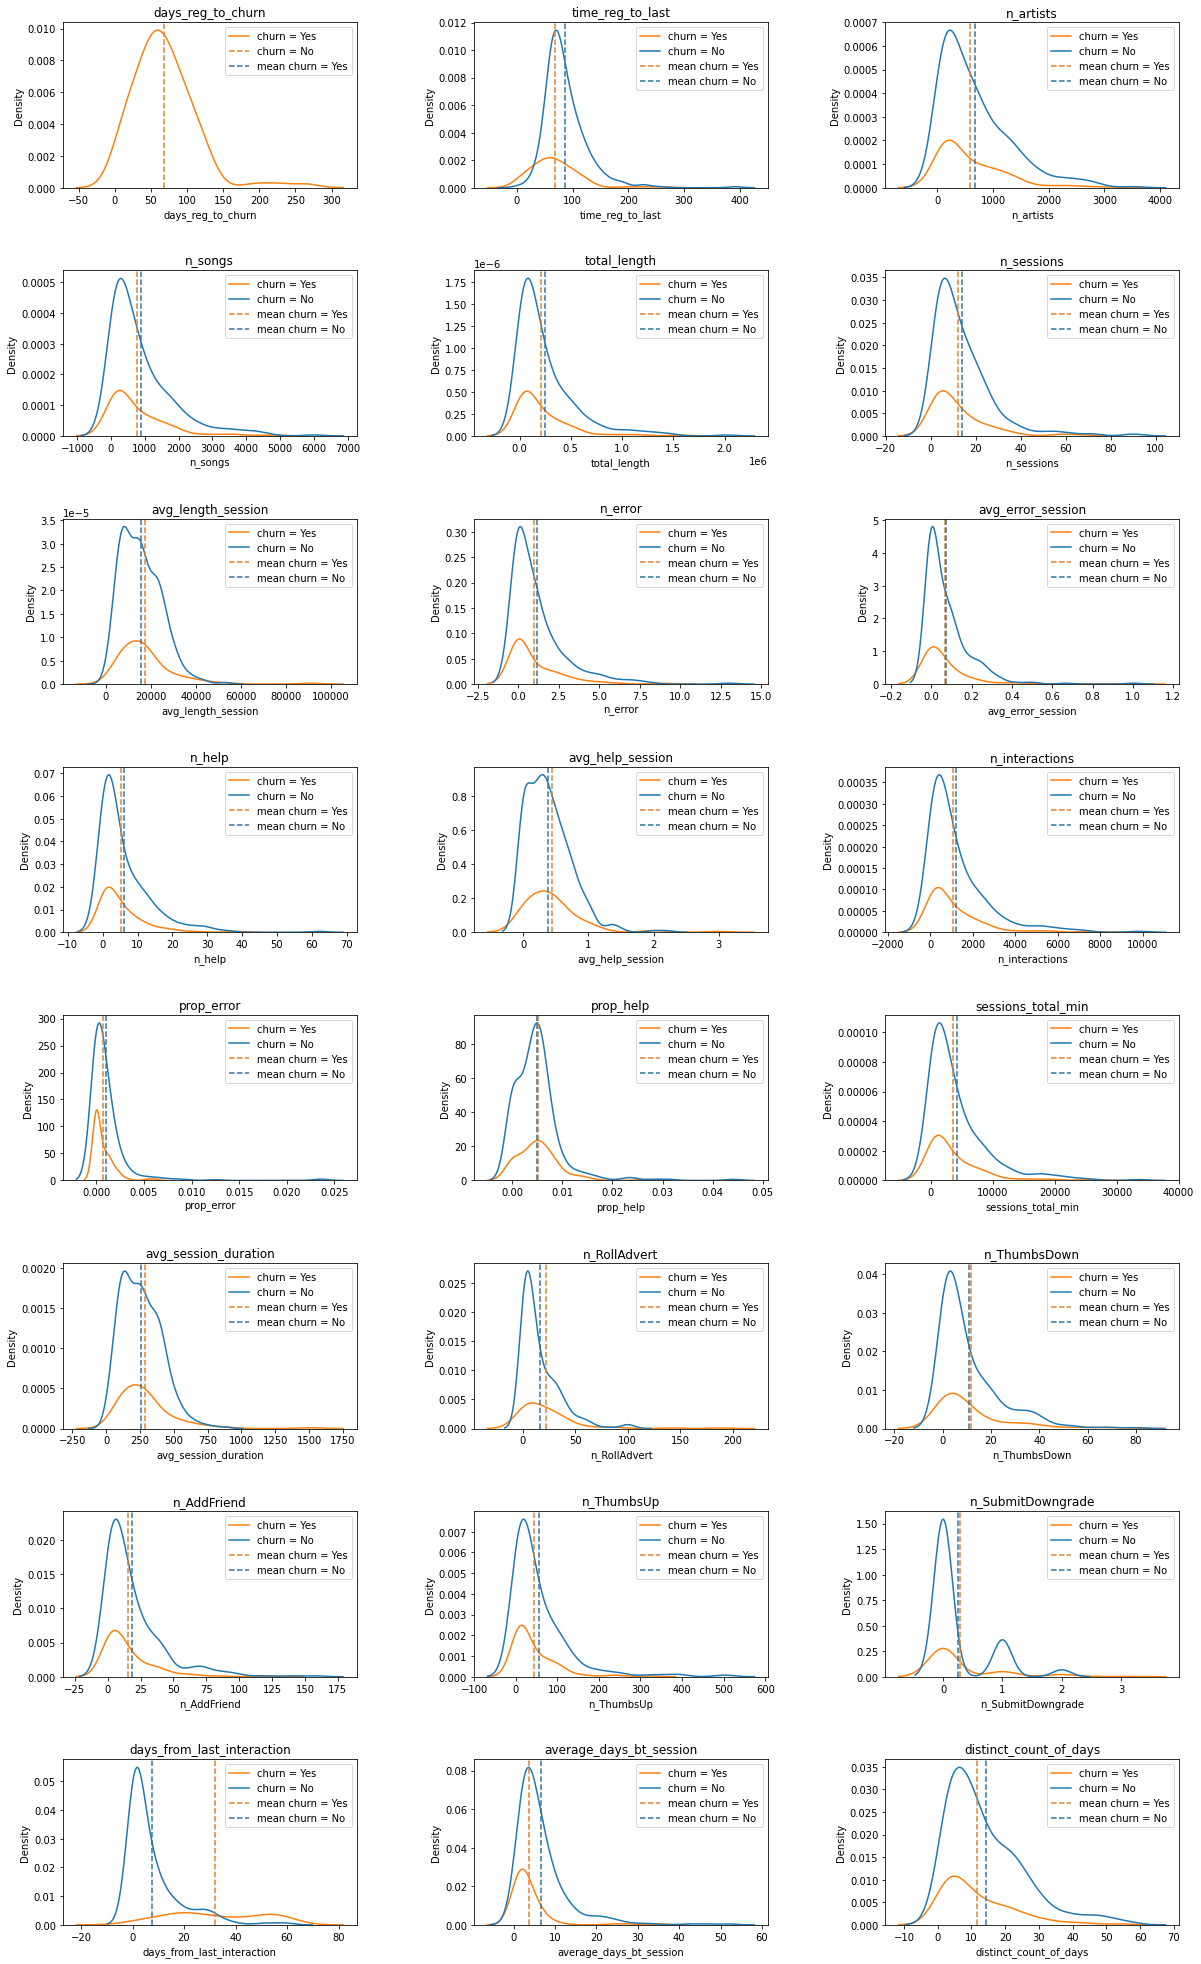

In [71]:
fig = plt.figure(figsize=(20, 35))
rows = int(n_cols / 3) + (n_cols % 3 > 0)

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(rows,3,i+1)
    ax.set_title(cols_interest[i])
    sns.kdeplot(data=df_users, x=coln, hue='churn_cancellation', legend=True)
    ax.axvline(df_users[(df_users.churn_cancellation == 1)][cols_interest[i]].mean(), color='#e1812c', linestyle='--')
    ax.axvline(df_users[(df_users.churn_cancellation == 0)][cols_interest[i]].mean(), color='#3274a1', linestyle='--')
    ax.legend(['churn = Yes','churn = No','mean churn = Yes','mean churn = No'], fontsize=10)
 
fig.subplots_adjust(hspace=.5,wspace=0.4)    

plt.show()   
plt.close()

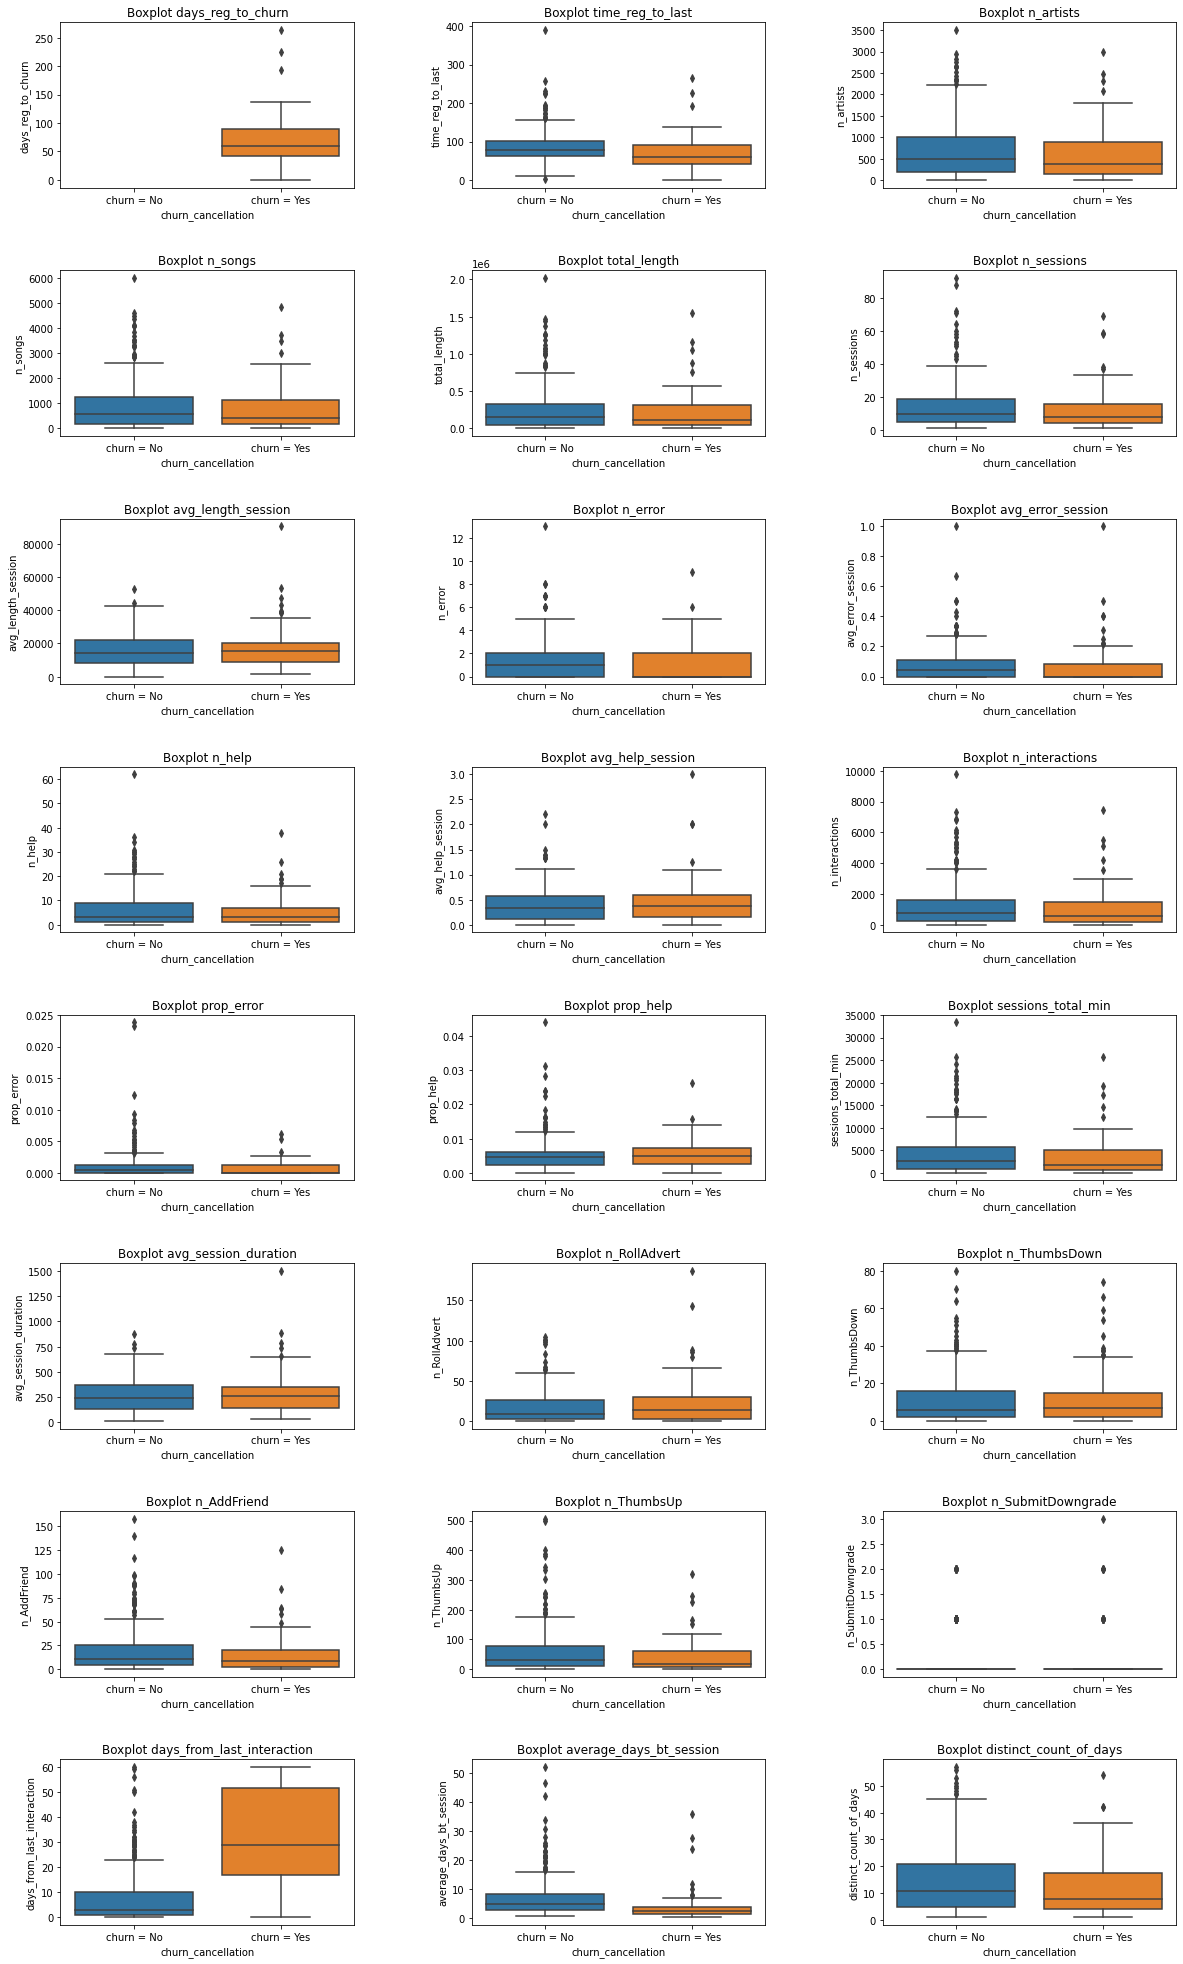

In [72]:
fig = plt.figure(figsize=(20, 35))
rows = int(n_cols / 3) + (n_cols % 3 > 0)

for i, coln in enumerate(cols_interest):
    ax = fig.add_subplot(rows,3,i+1)
    ax.set_title('Boxplot '+cols_interest[i])
    sns.boxplot(data=df_users, y=coln, x='churn_cancellation')
    ax.set_xticklabels(['churn = No','churn = Yes'])
 
fig.subplots_adjust(hspace=.5,wspace=0.4)    

plt.show()   
plt.close()

<font color='MediumBlue'>
Para visualizar la variable last_level (categórica), se realiza un gráfico de torta para revisar si la distribución cambia entre las clases:

In [73]:
churn_yes = df_users[df_users.churn_cancellation == 1]
churn_no = df_users[df_users.churn_cancellation == 0]
def labeling_yes(val):
    return f'{val / 100 * len(churn_yes):.0f}\n{val:.0f}%'
def labeling_no(val):
    return f'{val / 100 * len(churn_no):.0f}\n{val:.0f}%'

In [74]:
colors_churn = ['tab:orange','gold']
colors_nochurn = ['tab:blue','cornflowerblue']

Text(0, 0.5, 'Last Level')

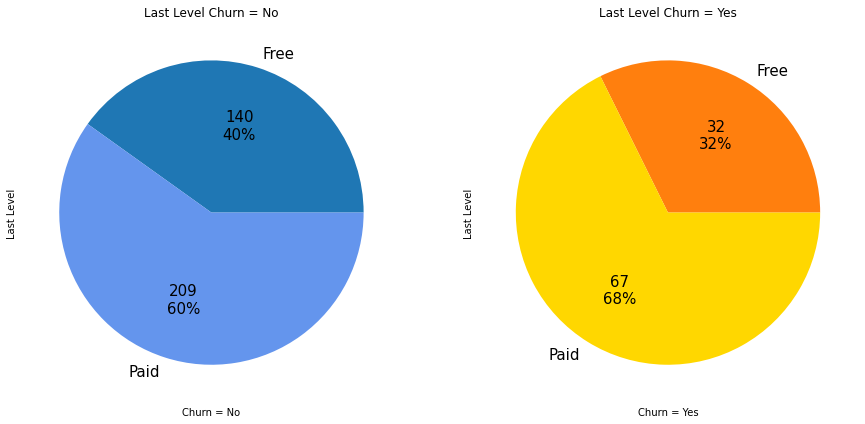

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 15))

ax1.set_title('Last Level Churn = No')
churn_no.groupby(df_users.last_level).size().plot(kind='pie', autopct=labeling_no, textprops={'fontsize': 15},colors=colors_nochurn, ax=ax1, labels=['Free', 'Paid'])
ax1.set_xlabel('Churn = No', size=10)
ax1.set_ylabel('Last Level', size=10)

ax2.set_title('Last Level Churn = Yes')
churn_yes.groupby(df_users.last_level).size().plot(kind='pie', autopct=labeling_yes, textprops={'fontsize': 15},colors=colors_churn, ax=ax2, labels=['Free', 'Paid'])
ax2.set_xlabel('Churn = Yes', size=10)
ax2.set_ylabel('Last Level', size=10)

<font color='MediumBlue'>
En cuanto a las variables que analizan la evolución en el tiempo (vistas acumuladas de la página de error y la página de ayuda por usuario), puede complicarse visualizar gráficamente. Podría chequearse, por ejemplo, un usuario puntual. El usuario 12 vió la página de error 5 veces y puede resultar interesante:

(array([736968., 736975., 736982., 736989., 736999., 737006., 737013.,
        737020., 737029.]), <a list of 9 Text major ticklabel objects>)

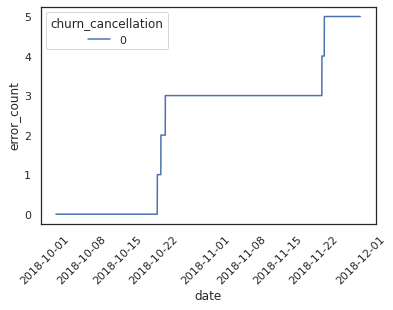

In [76]:
user = 12
data = df_tp2[df_tp2.userId == user] 
x = data['date']
y = data['error_count']
hue = data['churn_cancellation']
sns.set_theme(style="white")

sns.lineplot(x=x, y=y, hue=hue, data=df_tp2)
plt.xticks(rotation=45)

<font color='MediumBlue'>
De forma similar, el usuario 2 vio 7 veces la página de error:

(array([736975., 736982., 736989., 736999., 737006., 737013., 737020.,
        737029.]), <a list of 8 Text major ticklabel objects>)

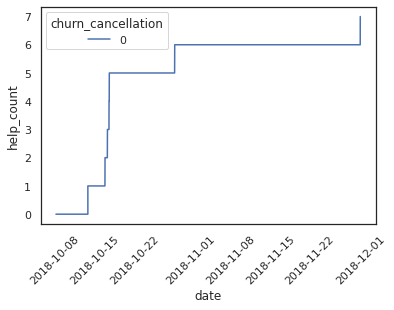

In [77]:
user = 2
data = df_tp2[df_tp2.userId == user] 
x = data['date']
y = data['help_count']
hue = data['churn_cancellation']
sns.set_theme(style="white")

sns.lineplot(x=x, y=y, hue=hue, data=df_tp2)
plt.xticks(rotation=45)

<font color='MediumBlue'>
Para visualizar el comportamiento de todos los usuarios en simultáneo, se realiza un gráfico de la media de la variable para usuarios que hicieron churn y la media para usuarios que no hicieron churn, por día, para evaluar si los comportamientos difieren:

In [78]:
# En una copia del df, agrupamos los eventos de un mismo día
aux =  df_tp2.copy()
aux['new_date'] = pd.to_datetime(aux['date']).dt.date

# Armamos los dataframes agrupados para graficar
daily_error = aux.groupby(by=['new_date','userId','churn_cancellation'],sort=False)['error_count'].mean()\
                                                                              .sort_values(ascending=False)\
                                                                              .reset_index()\
                                                                              .rename(columns={'index': 'new_date'})
daily_help = aux.groupby(by=['new_date','userId','churn_cancellation'],sort=False)['help_count'].mean()\
                                                                              .sort_values(ascending=False)\
                                                                              .reset_index()\
                                                                              .rename(columns={'index': 'new_date'})

(array([736968., 736975., 736982., 736989., 736999., 737006., 737013.,
        737020., 737029.]), <a list of 9 Text major ticklabel objects>)

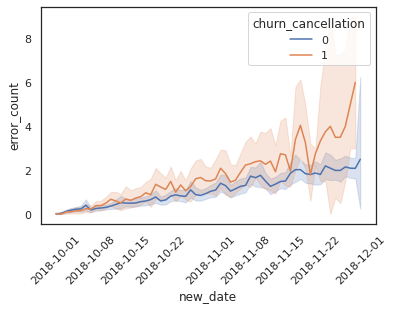

In [79]:
x = daily_error['new_date']
y = daily_error['error_count']
hue = daily_error['churn_cancellation']
sns.lineplot(x=x, y=y, hue=hue)
plt.xticks(rotation=45)

(array([736968., 736975., 736982., 736989., 736999., 737006., 737013.,
        737020., 737029.]), <a list of 9 Text major ticklabel objects>)

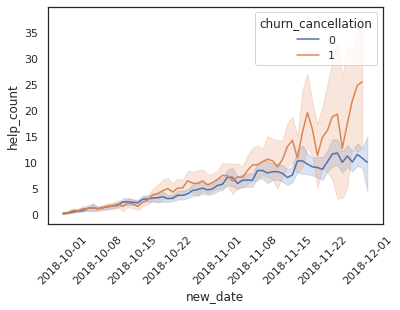

In [80]:
x = daily_help['new_date']
y = daily_help['help_count']
hue = daily_help['churn_cancellation']
sns.lineplot(x=x, y=y, hue=hue)
plt.xticks(rotation=45)

### b. Pasar las variables categóricas (strings) a numéricas. Analizar diferentes métodos para elegir el más adecuado (One hot encoding, categorías numéricas).

####Día de semana si/no: 1 / 0

In [81]:
# 0 a 4 son lunes a viernes, 5 y 6 son sábado y domingo
df_tp2['if_week_day']=df_tp2.day_week.apply(lambda x: 1 if x <= 4 else 0) 
df_tp2[['day_week', 'if_week_day']].sample(5)

,day_week,if_week_day
297992,1,1
293519,2,1
14205,1,1
35047,6,0
515801,2,1


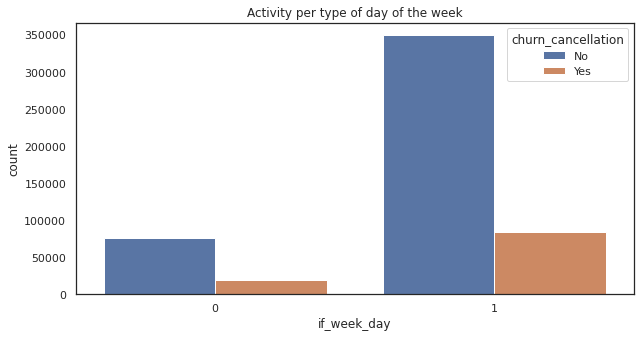

In [82]:
plt.figure(figsize = (10,5))
g = sns.countplot(x='if_week_day', data=df_tp2, hue='churn_cancellation')
g.set(title='Activity per type of day of the week')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

####Género como 0 / 1
Si es hombre 1, sino 0.

In [83]:
# 1 si gender es M, 0 si es F
df_tp2['if_male']=df_tp2.gender.apply(lambda x: 1 if x == 'M' else 0) 
df_tp2[['gender', 'if_male']].sample(5)

,gender,if_male
83204,F,0
491714,F,0
140673,M,1
212081,M,1
200814,F,0


####Dispositivo utilizado iPhone si/no: 1/0

In [84]:
# 1 si Operating_System es iPhone, 0 en el caso contraio
df_tp2['if_iPhone']=df_tp2.Operating_System.apply(lambda x: 1 if x == 'iPhone' else 0) 
df_tp2[['Operating_System', 'if_iPhone']].sample(10)

,Operating_System,if_iPhone
442109,Macintosh,0
57187,Windows,0
425884,iPhone,1
318252,Windows,0
519935,Windows,0
284921,Macintosh,0
507046,Windows,0
252312,Macintosh,0
506561,Windows,0
217238,Macintosh,0


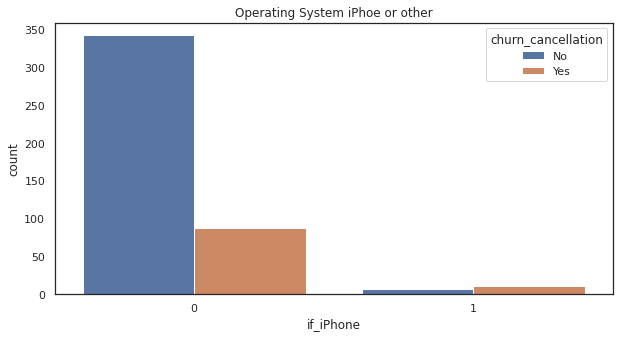

In [85]:
plt.figure(figsize = (10,5))
df_sistOper=df_tp2[['userId', 'if_iPhone','churn_cancellation']].drop_duplicates(subset =['userId', 'if_iPhone', 'churn_cancellation'], keep = 'first')
g = sns.countplot(x='if_iPhone', data=df_sistOper, hue='churn_cancellation')
g.set(title='Operating System iPhoe or other')
h, l = g.get_legend_handles_labels()
plt.legend(title='churn_cancellation', handles=h, labels=['No', 'Yes'])

####Eventos positivos/neutros/negativos: transformar a 1 / 0 / -1

In [86]:
def event_type_to_numeric(x):
    cat = 0
    if x == 'positive':
        cat = 1
    elif x ==  'negative':
        cat = -1
    else:
        cat = 0
    return cat

In [87]:
df_tp2['event_type_numeric']=df_tp2.event_type.apply(event_type_to_numeric)

####Página de error si/no: 1 / 0

In [88]:
# 1 si page es "Error", 0 en caso contrario
df_tp2['if_error']=df_tp2.page.apply(lambda x: 1 if x == 'Error' else 0) 
df_tp2[(df_tp2.page == 'Error') | (df_tp2.page == 'Help')][['page', 'if_error']].sample(5)

,page,if_error
45623,Help,0
429774,Help,0
282116,Help,0
277778,Help,0
192202,Help,0


####Página de ayuda si/no: 1 / 0

In [89]:
# 1 si page es "Help", 0 en caso contrario
df_tp2['if_help']=df_tp2.page.apply(lambda x: 1 if x == 'Help' else 0) 
df_tp2[(df_tp2.page == 'Error') | (df_tp2.page == 'Help')][['page', 'if_error','if_help']].sample(5)

,page,if_error,if_help
527816,Help,0,1
165125,Help,0,1
88357,Help,0,1
261411,Help,0,1
97958,Help,0,1


#### Dataframe

<font color='MediumBlue'>
Finalmente se tienen las siguientes columnas:

In [90]:
df_tp2.columns

Index(['userId', 'ts', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length',
       'date', 'hour', 'day_week', 'day', 'month', 'year',
       'churn_cancellation', 'churn_downgrade',
       'churn_cancellation_or_downgrade', 'event_type', 'Operating_System',
       'State', 'Region', 'days_reg_to_churn', 'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_co

In [91]:
pd.set_option('display.max_rows', 61)


In [92]:
status(df_tp2)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,userId,0,0.0,0,0.000000,448,int64
1,ts,0,0.0,0,0.000000,499351,int64
2,sessionId,0,0.0,0,0.000000,4470,int64
3,page,0,0.0,0,0.000000,19,object
4,auth,0,0.0,0,0.000000,2,object
...,...,...,...,...,...,...,...
60,help_count,0,0.0,79388,0.150355,63,int64
61,if_week_day,0,0.0,94691,0.179337,2,int64
62,if_male,0,0.0,225393,0.426877,2,int64
63,if_iPhone,0,0.0,513524,0.972574,2,int64


<font color='MediumBlue'>
Se descarta days_reg_to_churn por tener un 80% de datos nulos. Si bien es una variable interesante, no se tendrá nunca el dato para un usuario que no haya hecho churn, por lo que resulta imposible incorporar en un modelo.</br>
En cuanto a la variable average_days_bt_session, debido a que se observaron diferencias entre los grupos, se eliminaran los registros que tengan nulos para esa columna. Estos registros representan el 0.3% del total de los datos.

In [93]:
len(df_tp2)

528005

In [94]:
# Se guarda la salida por las dudas se quiera volver
df_tp2_original = df_tp2.copy()

In [95]:
df_tp2 = df_tp2.dropna(subset=['average_days_bt_session'])

In [96]:
len(df_tp2)

526178

In [97]:
1- (len(df_tp2)/len(df_tp2_original))

0.0034601945057338712

<font color='MediumBlue'>
Finalmente, es necesario armar un nuevo dataframe que no tenga las variables categóricas que se recodificaron, y chequear que se hará con las columnas que tengan registros nulos. También se descartarán las columnas que definitivamente no serán usadas.</br>

In [98]:
df_tp2.columns

Index(['userId', 'ts', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length',
       'date', 'hour', 'day_week', 'day', 'month', 'year',
       'churn_cancellation', 'churn_downgrade',
       'churn_cancellation_or_downgrade', 'event_type', 'Operating_System',
       'State', 'Region', 'days_reg_to_churn', 'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_co

In [99]:
df_tp2 = df_tp2[['userId', 'ts', 'sessionId', 'hour', 'day_week', 'day', 'month', 'year',
       'churn_cancellation', 'churn_downgrade',
       'churn_cancellation_or_downgrade',  'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_count']]

In [100]:
df_tp2.shape

(526178, 40)

In [101]:
df_tp2_original.shape

(528005, 65)

### c. Transformar los features para que tengan distribuciones más cercanas a la normal (elegir qué método es más conveniente: escalar, normalizar, estandarizar)

In [102]:
relevant_columns= ['hour', 'day_week', 'day', 'month', 'last_level',
       'time_reg_to_last', 'n_artists', 'n_songs', 'total_length',
       'total_length_session', 'n_sessions', 'avg_length_session', 'n_error',
       'avg_error_session', 'n_help', 'avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'sessions_total_min', 'avg_session_duration',
       'n_RollAdvert', 'n_ThumbsDown', 'n_AddFriend', 'n_ThumbsUp',
       'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'distinct_count_of_days', 'if_error',
       'error_count', 'if_help', 'help_count']

In [103]:
status(df_tp2[relevant_columns])

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,hour,0,0.0,21341,0.040559,24,int64
1,day_week,0,0.0,79948,0.151941,7,int64
2,day,0,0.0,0,0.000000,31,int64
3,month,0,0.0,0,0.000000,3,int64
4,last_level,0,0.0,0,0.000000,2,object
5,time_reg_to_last,0,0.0,0,0.000000,424,float64
6,n_artists,0,0.0,0,0.000000,363,int64
7,n_songs,0,0.0,0,0.000000,378,int64
8,total_length,0,0.0,0,0.000000,424,float64
9,total_length_session,0,0.0,197,0.000374,5897,float64


In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
df_tp2_orig = df_tp2[relevant_columns].copy(deep=True)
df_tp2_scld = scaler.fit_transform(df_tp2_orig)
df_tp2_scld = pd.DataFrame(df_tp2_scld, columns=df_tp2_orig.columns)
df_tp2_scld.sample(5)

,hour,day_week,day,month,last_level,time_reg_to_last,n_artists,n_songs,total_length,total_length_session,...,n_AddFriend,n_ThumbsUp,n_SubmitDowngrade,days_from_last_interaction,average_days_bt_session,distinct_count_of_days,if_error,error_count,if_help,help_count
303288,0.478261,0.833333,0.300000,0.5,1.0,0.267961,0.362986,0.281172,0.228278,0.080236,...,0.272152,0.191700,0.333333,0.000000,0.045634,0.418182,0.0,0.076923,0.0,0.306452
384240,0.913043,0.333333,0.433333,0.5,1.0,0.417900,0.339817,0.253724,0.209949,0.168850,...,0.183544,0.185771,0.000000,0.067797,0.055441,0.290909,0.0,0.000000,0.0,0.080645
218416,0.391304,0.666667,0.266667,0.5,1.0,0.303886,0.750572,0.679665,0.619589,0.066635,...,0.512658,0.478261,0.000000,0.000000,0.022800,0.727273,0.0,0.384615,0.0,0.177419
189020,0.869565,0.666667,0.133333,0.0,0.0,0.199045,0.851259,0.805690,0.768006,0.171613,...,0.791139,0.630435,0.666667,0.000000,0.009371,0.945455,0.0,0.000000,0.0,0.064516
382420,0.130435,0.666667,0.500000,0.5,1.0,0.313418,0.661613,0.579414,0.518946,0.263026,...,0.531646,0.448617,0.333333,0.152542,0.010898,0.727273,0.0,0.307692,0.0,0.274194


### d. Analizar la posibilidad de incluir nuevas columnas con el método PCA (éste paso debe realizarse luego de escalar o estandarizar las variables, para que en las componentes PCA las variables sean “pesadas” de manera similar, y no tenga alto impacto la varianza de las columnas originales).

In [105]:
from sklearn.decomposition import PCA
pre_pca= df_tp2_scld.copy(deep=True)
n = min(30, pre_pca.shape[1]) 
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(pre_pca)
print(principalComponents.shape)
# pre_pca[['Principal Component 1', 'Principal Component 2', 'Principal Component 3']] = principalComponents[:,:3] #Tomamos el dataframe de la matriz a la cual se le aplicó PCA

(526178, 30)


In [106]:
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Explained variance ratio
[4.27065544e-01 1.31577341e-01 7.42854219e-02 6.79857097e-02
 6.44769386e-02 5.10951775e-02 4.60652662e-02 2.77304214e-02
 2.07474217e-02 1.73848278e-02 1.56936342e-02 1.01093011e-02
 8.47824771e-03 6.72070402e-03 5.32533242e-03 4.91903433e-03
 3.98409258e-03 3.73426187e-03 3.52329419e-03 2.24582362e-03
 1.83103926e-03 1.18700124e-03 9.53028189e-04 7.60644669e-04
 7.11486251e-04 5.81868068e-04 2.88772264e-04 2.21195974e-04
 1.98510227e-04 9.71618603e-05]


In [107]:
pca_df=pd.DataFrame(data= pca.components_, columns = df_tp2_scld.columns, index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25','PC26','PC27','PC28','PC29','PC30'])
pca_df[relevant_columns]

,hour,day_week,day,month,last_level,time_reg_to_last,n_artists,n_songs,total_length,total_length_session,...,n_AddFriend,n_ThumbsUp,n_SubmitDowngrade,days_from_last_interaction,average_days_bt_session,distinct_count_of_days,if_error,error_count,if_help,help_count
PC1,-0.006651,0.012889,0.020508,0.019831,0.058097,-0.000329,0.299016,0.292661,0.283535,0.041647,...,0.278039,0.272657,0.094672,-0.087899,-0.043644,0.323382,0.000094,0.135566,-0.000020,0.113376
PC2,0.032071,-0.042699,0.015688,-0.046612,-0.877162,0.004727,-0.021675,-0.006826,0.002392,-0.120134,...,0.016740,-0.008985,0.277229,-0.000520,-0.000158,0.060236,0.000050,0.005125,0.000005,0.004200
PC3,-0.571047,0.766736,-0.182372,0.201918,-0.068432,0.000180,-0.005968,-0.006131,-0.006104,0.057777,...,-0.007284,-0.022984,0.030915,-0.008685,-0.000172,-0.004891,0.000015,0.028472,0.000215,0.026175
PC4,0.145889,-0.142059,-0.959029,0.124211,0.025718,-0.003309,0.006894,0.008649,0.009655,-0.027407,...,0.017242,0.023297,0.031095,0.089003,-0.011288,0.013125,-0.000144,-0.057894,-0.000034,-0.065937
PC5,0.797624,0.554743,0.058902,0.195842,0.028457,0.005609,-0.013026,-0.012109,-0.011275,-0.015004,...,-0.011001,-0.002835,0.015047,-0.042674,0.003975,0.006946,-0.000166,0.049644,0.000662,0.050569
PC6,0.037742,0.272741,-0.075726,-0.845318,0.131152,-0.033053,0.011845,0.012956,0.014081,-0.115428,...,0.020613,0.061582,0.029389,0.193011,-0.028541,0.047920,-0.000177,-0.200014,-0.000405,-0.217450
PC7,0.114145,0.071255,-0.082639,-0.227468,-0.364178,-0.013222,0.059708,0.055371,0.049650,0.289680,...,0.012421,-0.113763,-0.045092,0.060632,0.041984,-0.151322,0.000454,-0.016318,0.001396,-0.027299
PC8,0.000252,-0.037308,0.038525,0.021782,0.244966,-0.007468,-0.034951,-0.048038,-0.055147,0.152681,...,-0.073222,-0.168092,0.800831,0.161787,-0.027393,-0.068154,0.000271,0.068598,0.000425,0.017532
PC9,-0.006089,-0.002678,0.036720,0.044142,-0.014160,-0.165794,-0.077893,-0.029968,0.002140,-0.199978,...,0.039493,-0.032085,-0.206582,0.688967,-0.002423,-0.144534,0.002445,0.377705,-0.000346,0.153328
PC10,0.024052,-0.031338,0.036393,0.028381,-0.044434,-0.038433,0.009076,0.009566,0.010334,0.823929,...,0.035673,0.051056,-0.151417,0.351671,-0.052397,0.054290,-0.001555,-0.046573,-0.002188,0.035397


<font color='MediumBlue'>
Se puede apreciar para la primer componente las variables n_song, n_artists, lenght, entre otras son las que mayor peso tienen.

<Figure size 1080x360 with 0 Axes>

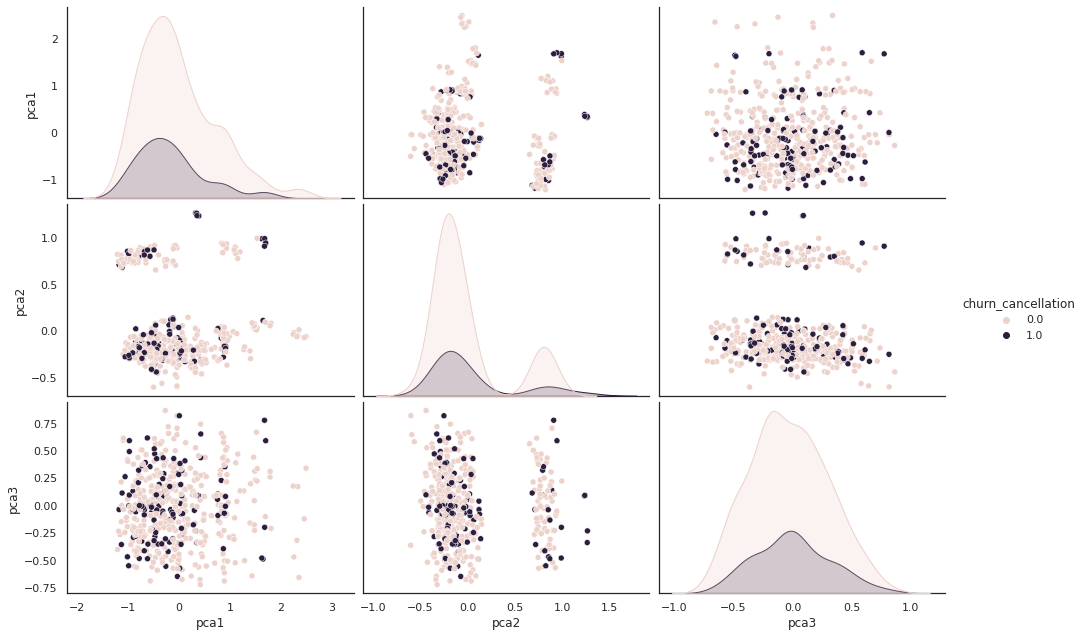

In [108]:
# Intento para ver cómo se diferencian las clases por las componentes
fig = plt.figure(figsize=(15, 5))
df_graficar = pd.DataFrame()
df_graficar[['pca1', 'pca2','pca3']] = principalComponents[:,:3]
df_graficar = pd.concat([df_graficar, df_tp2['churn_cancellation']], axis=1)
sns.pairplot(data=df_graficar.sample(500), hue='churn_cancellation', height=3, aspect= 1.5)

<font color=mediumblue> Al aplicar PCA sobre las variables seleccionadas de la base de datos se observa que las primeras 3 componentes resumen un 63,3% de la variabilidad. No obstante esto, al graficarlas, no parecen estar explicando el comportamiento de la variable objetivo ya que los puntos de ambos grupos estan superpuestos. <br>
Se incluiran en el dataframe las primeras 3 componentes y se evaluara su inclusion en los modelos en los practicos siguientes.

In [109]:
pca_comp = pd.DataFrame()
pca_comp[['pca1', 'pca2','pca3']] = principalComponents[:,:3]
df_tp2_scld = pd.concat([df_tp2_scld,pca_comp], axis=1)
df_tp2_scld

,hour,day_week,day,month,last_level,time_reg_to_last,n_artists,n_songs,total_length,total_length_session,...,days_from_last_interaction,average_days_bt_session,distinct_count_of_days,if_error,error_count,if_help,help_count,pca1,pca2,pca3
0,0.173913,0.000000,0.233333,0.0,1.0,0.195229,0.177632,0.122176,0.093219,0.015062,...,0.000000,0.096735,0.163636,0.0,0.0,0.0,0.000000,-0.698226,-0.200050,-0.158678
1,0.173913,0.000000,0.233333,0.0,1.0,0.195229,0.177632,0.122176,0.093219,0.015062,...,0.000000,0.096735,0.163636,0.0,0.0,0.0,0.000000,-0.698226,-0.200050,-0.158678
2,0.173913,0.000000,0.233333,0.0,1.0,0.195229,0.177632,0.122176,0.093219,0.015062,...,0.000000,0.096735,0.163636,0.0,0.0,0.0,0.000000,-0.698226,-0.200050,-0.158678
3,0.217391,0.000000,0.233333,0.0,1.0,0.195229,0.177632,0.122176,0.093219,0.015062,...,0.000000,0.096735,0.163636,0.0,0.0,0.0,0.000000,-0.698515,-0.198656,-0.183506
4,0.217391,0.000000,0.233333,0.0,1.0,0.195229,0.177632,0.122176,0.093219,0.015062,...,0.000000,0.096735,0.163636,0.0,0.0,0.0,0.000000,-0.698515,-0.198656,-0.183506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526173,0.434783,0.166667,0.866667,0.5,1.0,0.059506,0.198799,0.134561,0.104728,0.034402,...,0.067797,0.043159,0.181818,0.0,0.0,0.0,0.129032,-0.592978,-0.219719,-0.194580
526174,0.434783,0.166667,0.866667,0.5,1.0,0.059506,0.198799,0.134561,0.104728,0.034402,...,0.067797,0.043159,0.181818,0.0,0.0,0.0,0.129032,-0.592978,-0.219719,-0.194580
526175,0.478261,0.166667,0.866667,0.5,1.0,0.059506,0.198799,0.134561,0.104728,0.034402,...,0.067797,0.043159,0.181818,0.0,0.0,0.0,0.129032,-0.593267,-0.218324,-0.219408
526176,0.478261,0.166667,0.866667,0.5,1.0,0.059506,0.198799,0.134561,0.104728,0.034402,...,0.067797,0.043159,0.181818,0.0,0.0,0.0,0.129032,-0.593267,-0.218324,-0.219408


## 3. Correlaciones

### a. Verificar mediante una matriz de correlación la correlación entre features y entre cada variable y la columna target.

Text(0.5, 1.0, 'Correlation between Variables')

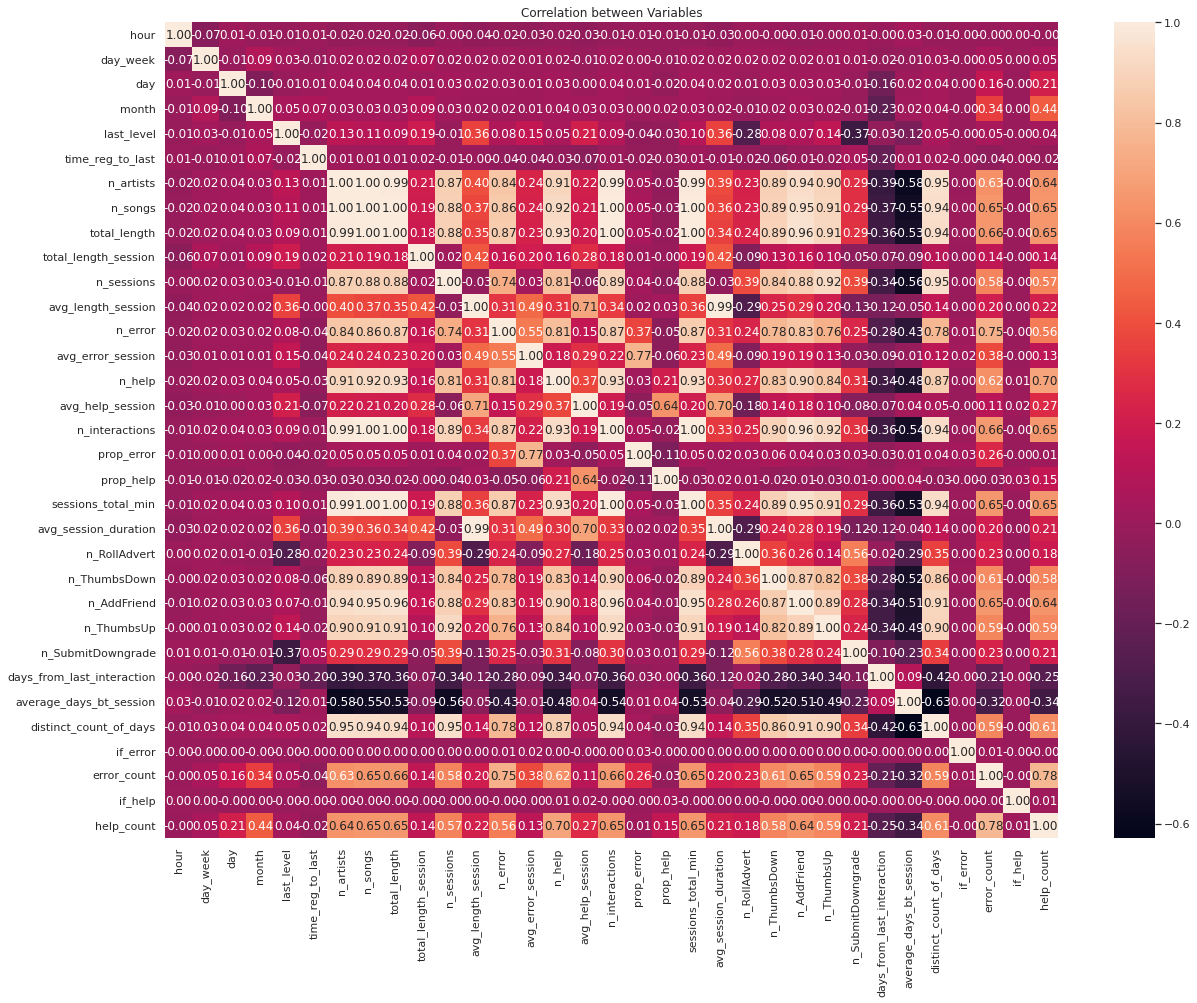

In [110]:
plt.figure(figsize=(20,15))
sns.heatmap(df_tp2_scld[relevant_columns].corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=12)

<font color=MediumBlue> Se observa colinealidad entre n_interactions y otras variables como: n_artists, n_songs, total_length y sessions_total_min.

### b. Eliminar los features fuertemente correlacionadas (una de cada par), ya que mantener columnas altamente correlacionadas, puede ocasionar un comportamiento no deseado en los modelos de clasificación.

<font color=MediumBlue> Se hace una nueva selección de columnas, buscando reducir la colinealidad entre las variables.

In [111]:
new_relevant= ['hour', 'day_week', 'day', 'month', 'last_level',
       'time_reg_to_last', 'total_length_session', 'n_error',
       'avg_error_session','avg_help_session', 'n_interactions',
       'prop_error', 'prop_help', 'avg_session_duration',
       'n_RollAdvert', 'n_SubmitDowngrade', 'days_from_last_interaction',
       'average_days_bt_session', 'if_error', 'if_help', 'help_count']

Text(0.5, 1.0, 'Correlation between Variables')

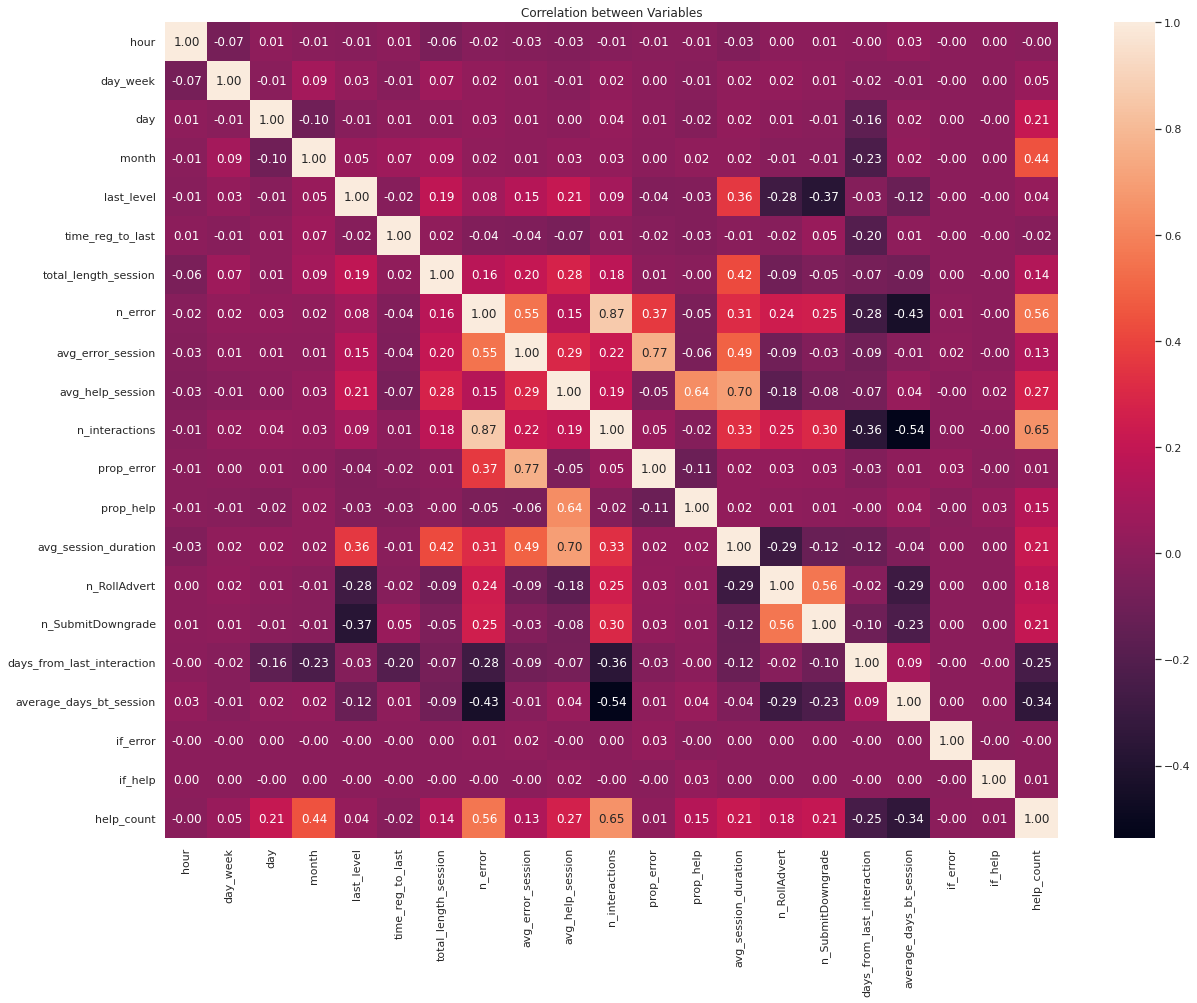

In [112]:
plt.figure(figsize=(20,15))
sns.heatmap(df_tp2_scld[new_relevant].corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=12)

## 4. Generar dataset “limpio”

### Guardar en un nuevo csv el dataset “limpio”, con las transformaciones y nuevas columnas, ya que será el que utilizaremos en los siguientes TP para un modelo de clasificación.

<font color=MediumBlue> Se exportará el dataset completo, teniendo presente el análisis de correlación realizado para los prácticos futuros.

In [113]:
df_tp2_scld.to_csv("salida_TP2.csv", index=None)
from google.colab import files
files.download('salida_TP2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>